In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tscv_sliding
from window_generator import WindowGenerator

In [2]:
from fredapi import Fred
fred_api_key = "29b81578246f3b1d8661dfdb956124ba"
fred = Fred(api_key=fred_api_key)
start_date = "2003-01-02" 
end_date = "2022-12-30"

In [3]:
vix = fred.get_series("VIXCLS", observation_start=start_date, observation_end=end_date).to_frame()
vix.head()

,0
2003-01-02,25.39
2003-01-03,24.68
2003-01-06,24.91
2003-01-07,25.13
2003-01-08,25.53


In [4]:
vix.rename(columns={0:"VIX"}, inplace=True)
vix

,VIX
2003-01-02,25.39
2003-01-03,24.68
2003-01-06,24.91
2003-01-07,25.13
2003-01-08,25.53
...,...
2022-12-26,NaN
2022-12-27,21.65
2022-12-28,22.14
2022-12-29,21.44


In [5]:
vix.fillna(method="ffill", inplace=True)

In [6]:
n = len(vix)
n_train = int(n*0.7)
n_val = int(n*0.9)
train_df = vix[0:n_train]
val_df = vix[n_train:n_val]
test_df = vix[n_val:]

In [7]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(3651, 1)
(1044, 1)
(522, 1)


In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

cols = train_df.columns
train_indices = train_df.index
val_indices = val_df.index
test_indices = test_df.index

scale = MinMaxScaler()
train_df = scale.fit_transform(train_df)
val_df = scale.transform(val_df)
test_df = scale.transform(test_df)

train_df = pd.DataFrame(train_df, columns=cols, index=train_indices)
val_df = pd.DataFrame(val_df, columns=cols, index=val_indices)
test_df = pd.DataFrame(test_df, columns=cols, index=test_indices)
train_df.head()

,VIX
2003-01-02,0.218402
2003-01-03,0.208398
2003-01-06,0.211639
2003-01-07,0.214739
2003-01-08,0.220375


In [9]:
input_width = 30

In [10]:
from sklearn.preprocessing import RobustScaler
w = WindowGenerator(input_width=input_width, 
                    label_width=1,
                    shift=1,
                    train_df=train_df,
                    val_df=val_df,
                    test_df=test_df,
                    n_splits=5,
                    train_splits=3,
                    test_splits=1)

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [12]:
def qlike(y_true, y_pred):
  return tf.math.log(y_pred) + (y_true / y_pred)

def build_model():
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(input_width, 1))) #(timesteps, features)
    model.add(LSTM(96, return_sequences=True)) #96 #192 #160
    #model.add(LSTM(256, return_sequences=True)) # #256 #(192)
    model.add(LSTM(64)) #64 
    model.add(Dropout(0.2)) #0.2 #0.1 #0.2
    model.add(Dense(1, activation="relu"))
    
    learning_rate = 0.001 #0.001 #0.0001 #0.001
    metrics = ["mse", "mae", "mape", tf.keras.metrics.RootMeanSquaredError(), qlike]
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics = metrics)
    return model
 

In [13]:
MAX_EPOCHS = 1
model = build_model()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=5)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-05-10 14:03:33.616138: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-10 14:03:33.616268: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
history = model.fit(w.train, epochs=MAX_EPOCHS,
                      validation_data=w.val,
                      callbacks=[early_stopping])

2023-05-10 14:03:34.485598: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-10 14:03:36.268227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-10 14:03:36.671738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-10 14:03:36.795888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-10 14:03:36.867161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-10 14:03:37.062167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-10 14:03:37.253034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

  3/114 [..............................] - ETA: 4s - loss: 0.0390 - mse: 0.0390 - mae: 0.1717 - mape: 75.5442 - root_mean_squared_error: 0.1975 - qlike: nan  

2023-05-10 14:03:37.374848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


114/114 [==============================] - ETA: 0s - loss: 0.0066 - mse: 0.0066 - mae: 0.0533 - mape: 11160.1260 - root_mean_squared_error: 0.0811 - qlike: nan

2023-05-10 14:03:41.871355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-10 14:03:42.019270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-10 14:03:42.075096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-10 14:03:42.148904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


114/114 [==============================] - 8s 48ms/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0533 - mape: 11160.1260 - root_mean_squared_error: 0.0811 - qlike: nan - val_loss: 0.0119 - val_mse: 0.0119 - val_mae: 0.0714 - val_mape: 244375.2656 - val_root_mean_squared_error: 0.1090 - val_qlike: -1.3372


In [15]:
ar_width = 200
shift = ar_width - input_width

test = np.concatenate([x for x, y in w.test], axis=0)
predictions = model.predict(test)
y = np.concatenate([y for x, y in w.test], axis=0).reshape(-1, 1)

predicted = scale.inverse_transform(predictions).flatten()[shift:]
actual = scale.inverse_transform(y).flatten()[shift:]
predicted.shape

2023-05-10 14:03:43.514454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-10 14:03:43.642774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-10 14:03:43.698569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 4/16 [======>.......................] - ETA: 0s 

2023-05-10 14:03:43.766602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 23ms/step


(322,)

<AxesSubplot: >

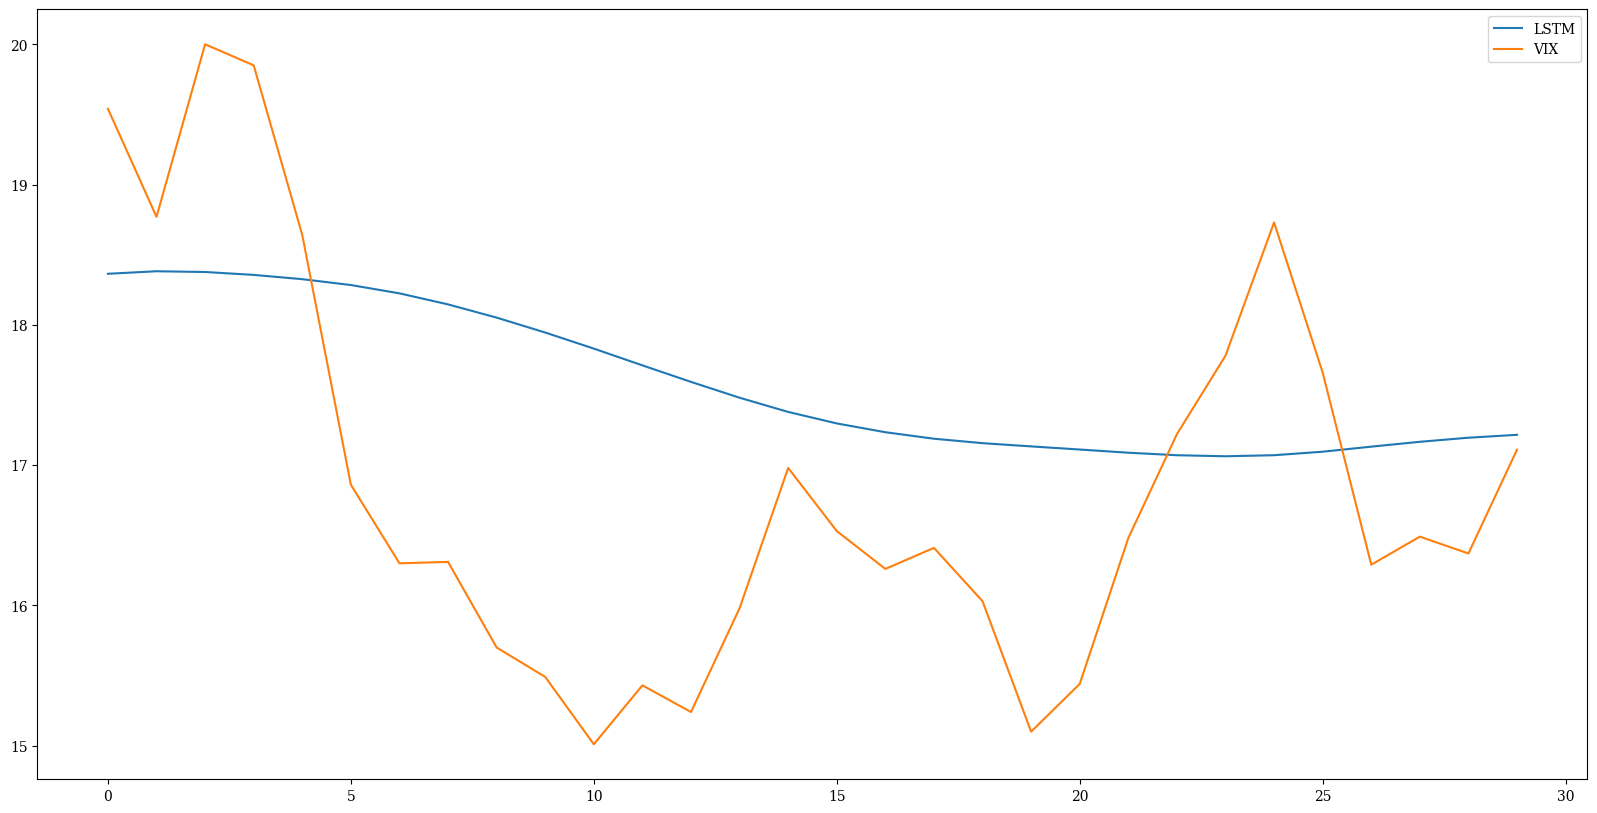

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
timesteps = np.array([i for  i in range(len(predicted))])
n = 30
sns.lineplot(ax = ax, x = timesteps[0:n], y = predicted[0:n], label = 'LSTM')
sns.lineplot(ax = ax, x = timesteps[0:n], y = actual[0:n], label = 'VIX')

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse =  mean_squared_error(actual, predicted)
mae =  mean_absolute_error(actual, predicted)

print("MSE: ", mse)
print("MAE: ", mae)

MSE:  44.710815
MAE:  5.4402695


In [18]:
import numpy as np

def mda(actual, predicted):
    """
    Calculates the Mean Directional Accuracy (MDA) for two time series.
    
    Parameters:
    actual (array-like): The actual values for the time series.
    predicted (array-like): The predicted values for the time series.
    
    Returns:
    float: The MDA value.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # calculate the signs of the differences between consecutive values
    actual_diff = np.diff(actual)
    actual_signs = np.sign(actual_diff)
    predicted_diff = np.diff(predicted)
    predicted_signs = np.sign(predicted_diff)
    
    # count the number of times the signs are the same
    num_correct = np.sum(actual_signs == predicted_signs)
    
    # calculate the MDA value
    mda = num_correct / (len(actual) - 1)
    
    return mda

mda(actual, predicted)

0.5015576323987538

In [19]:
import shap

y_train = np.concatenate([y for x, y in w.train], axis=0)
x_train = np.concatenate([x for x, y in w.train], axis=0)

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, x_train[:100])

/opt/homebrew/Caskroom/miniforge/base/envs/tensorload/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorload/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-usin

Econometric benchmark

In [20]:
input_width_ar = ar_width

ar_w = WindowGenerator(input_width=input_width_ar, 
                    label_width=1,
                    shift=1,
                    train_df=train_df,
                    val_df=val_df,
                    test_df=test_df,
                    n_splits=3,
                    train_splits=3,
                    test_splits=1,
                    scale=False)

In [21]:
y_test = np.concatenate([y for x, y in ar_w.test], axis=0)
x_test = np.concatenate([x for x, y in ar_w.test], axis=0)

In [22]:
from statsmodels.tsa.ar_model import AutoReg

predictions = []
resid = []

for x, y in zip(x_test, y_test):
    arima_model = AutoReg(endog=x, lags=3).fit()
    day_ahead = x_test.shape[1] + 1
    predictions.append(arima_model.predict(day_ahead, day_ahead))
    resid.append(y[0] - arima_model.predict(day_ahead, day_ahead))

(322, 1)
(492,)


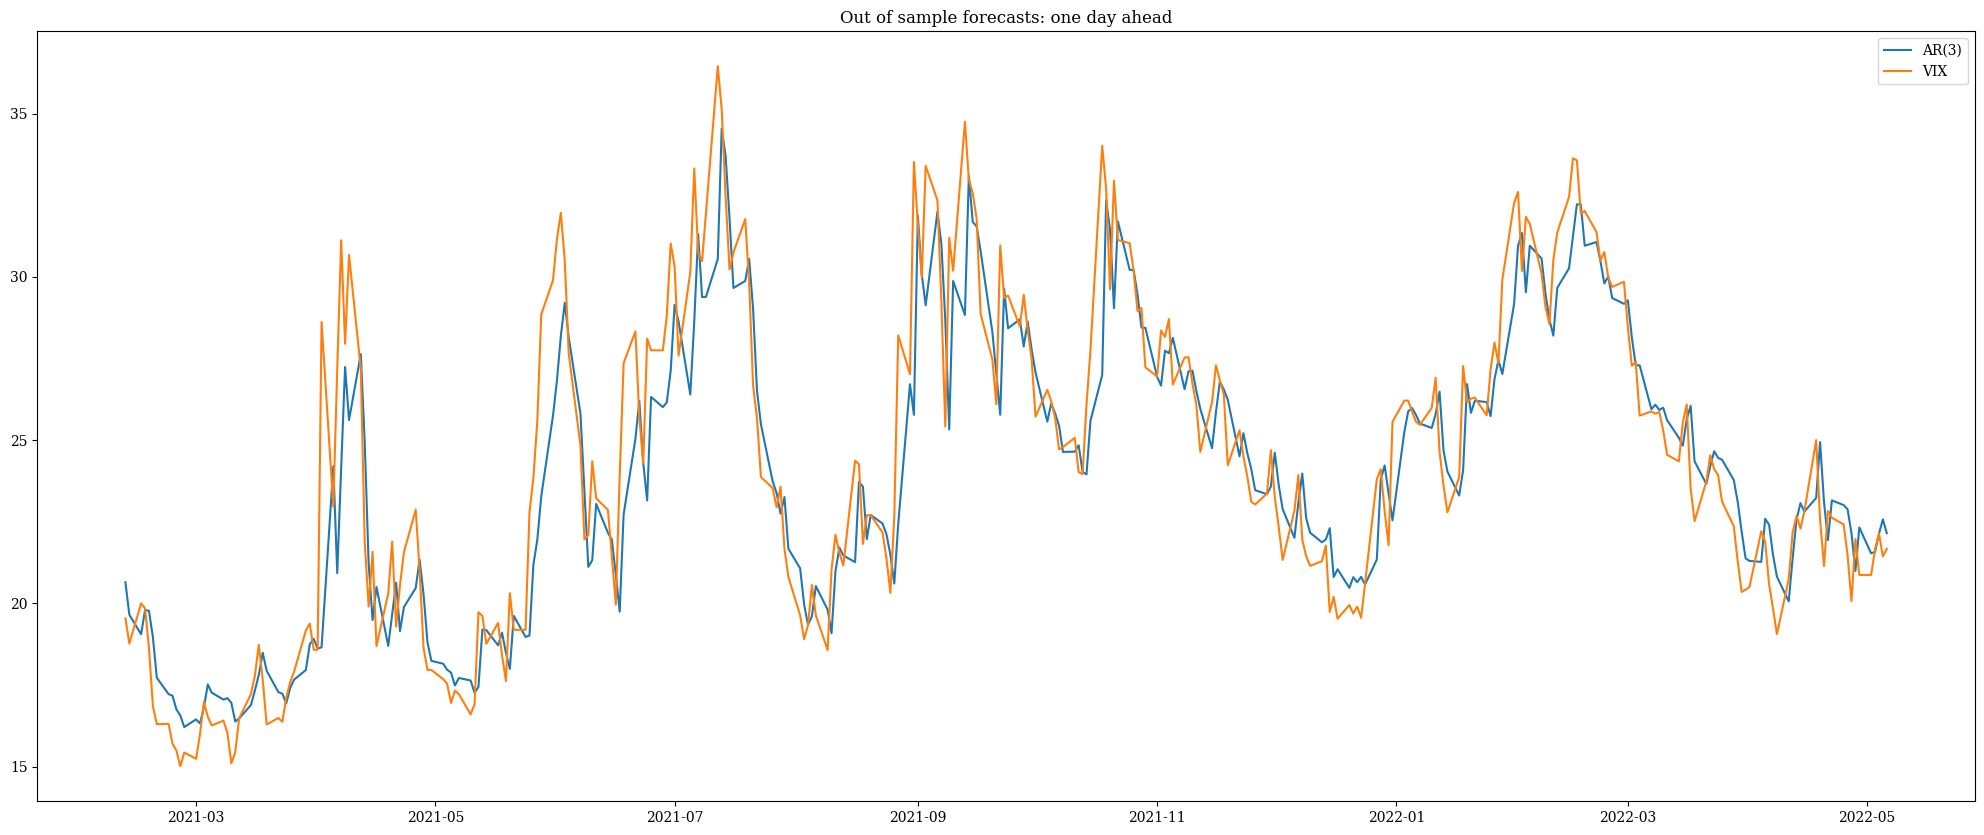

In [23]:
dates = np.arange(1, len(predictions) + 1)

y = scale.inverse_transform(y_test.reshape((len(predictions), -1)))
predictions = scale.inverse_transform(np.array(predictions))
print(y.shape)


dates = test_indices[input_width:]
print(dates.shape)

fig, ax = plt.subplots(figsize = (25,10))

n = 322 # How many days to see in plot

plt.plot(dates[:n], predictions[:n], label = "AR(3)")
plt.plot(dates[:n], y[:n], label = "VIX")
plt.title("Out of sample forecasts: one day ahead")
plt.legend()

In [24]:
mse = mean_squared_error(y, predictions)
mae = mean_absolute_error(y, predictions)

print("MSE: ", mse)
print("MAE: ", mae)

MSE:  3.7447612996363278
MAE:  1.3285389469830495


Bayesian model

In [144]:
import tensorflow_probability as tfp
tfd = tfp.distributions

negloglik = lambda y, rv_y: -rv_y.log_prob(y)

n_samples = np.concatenate([x for x, y in w.train], axis=0).shape[0]

"""
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])
"""

def posterior_mean_field(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size #number of total paramaeters (Weights and Bias)
    c = np.log(np.expm1(1.)) 
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype, initializer=lambda shape, dtype: random_gaussian_initializer(shape, dtype), trainable=True), 
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            # The Normal distribution with location loc and scale parameters.
            tfd.Normal(loc=t[..., :n],
                       scale=1e-5 +0.01*tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])


# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

ModuleNotFoundError: No module named 'tensorflow.random_normal_initializer'

In [ ]:
def build_bnn():
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(input_width, 1))) #(timesteps, features)
    model.add(LSTM(96, return_sequences=True)) #96 #192 #160
    #model.add(LSTM(256, return_sequences=True)) # #256 #(192)
    model.add(LSTM(64)) #64 
    model.add(Dropout(0.2)) #0.2 #0.1 #0.2
    model.add(tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/n_samples))
    #model.add(Dense(1, activation="relu"))
    
    learning_rate = 0.001 #0.001 #0.0001 #0.001
    metrics = ["mse", "mae", "mape", tf.keras.metrics.RootMeanSquaredError(), qlike]
    model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate), metrics = metrics)
    return model

In [ ]:
bnn = build_bnn()
bnn.summary()

NameError: name 'random_gaussian_initializer' is not defined

In [ ]:
MAX_EPOCHS = 250
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=50)

In [ ]:
history = bnn.fit(w.train, epochs=MAX_EPOCHS,
                      validation_data=w.val,
                      callbacks=[early_stopping])

Epoch 1/250
114/114 [==============================] - 5s 42ms/step - loss: 0.3575 - mse: 0.3574 - mae: 0.4579 - mape: 88569.8516 - root_mean_squared_error: 0.5979 - qlike: nan - val_loss: 0.2907 - val_mse: 0.2906 - val_mae: 0.4511 - val_mape: 1098201.6250 - val_root_mean_squared_error: 0.5391 - val_qlike: nan
Epoch 2/250
114/114 [==============================] - 5s 41ms/step - loss: 0.4111 - mse: 0.4110 - mae: 0.5138 - mape: 142632.2812 - root_mean_squared_error: 0.6411 - qlike: nan - val_loss: 0.2455 - val_mse: 0.2454 - val_mae: 0.3778 - val_mape: 1418744.2500 - val_root_mean_squared_error: 0.4954 - val_qlike: nan
Epoch 3/250
114/114 [==============================] - 5s 41ms/step - loss: 0.4197 - mse: 0.4197 - mae: 0.5099 - mape: 249423.0938 - root_mean_squared_error: 0.6478 - qlike: nan - val_loss: 0.2271 - val_mse: 0.2269 - val_mae: 0.3942 - val_mape: 1619767.8750 - val_root_mean_squared_error: 0.4764 - val_qlike: nan
Epoch 4/250
114/114 [==============================] - 5s 45ms

In [ ]:
b_x = np.concatenate([x for x, y in w.test], axis = 0)
b_y = np.concatenate([y for x, y in w.test], axis = 0)

ensemble = []

for i in range(100):
    ensemble.append(bnn(b_x))

ensemble = scale.inverse_transform(np.array(ensemble).reshape((100, -1)))

mean = np.mean(ensemble, axis = 0)
std = np.std(ensemble, axis = 0)

b_y = scale.inverse_transform(b_y.reshape((len(mean), -1)))


In [ ]:
b_y.shape

(492, 1)

In [ ]:
mse = mean_squared_error(b_y, mean)
mae = mean_absolute_error(b_y, mean)

print("MSE: ", mse)
print("MAE: ", mae)

MSE:  3.201116
MAE:  1.2487091


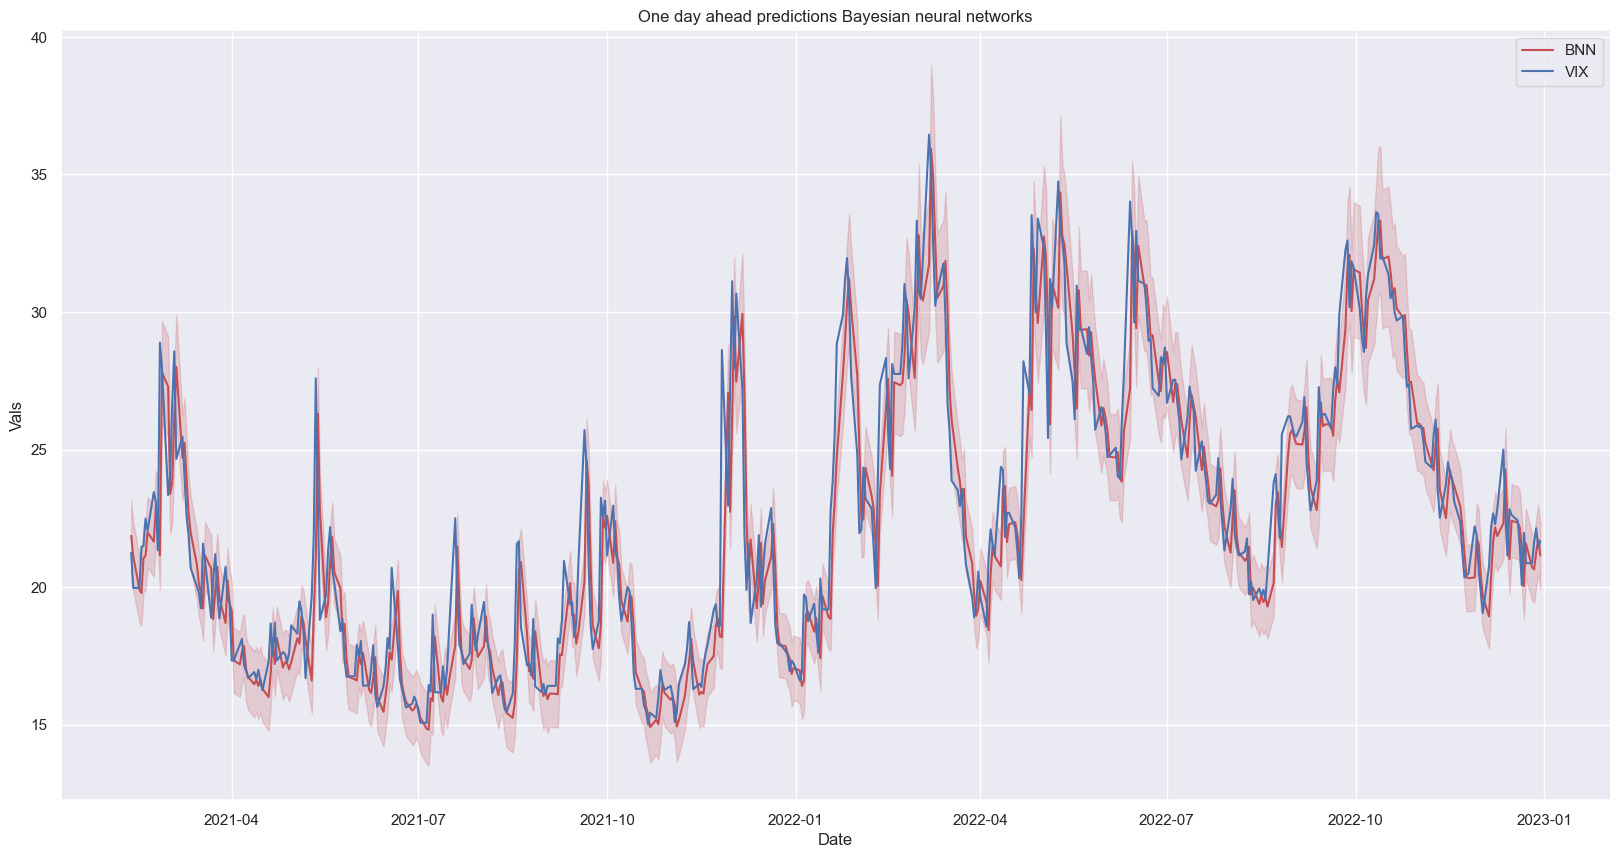

In [ ]:
test_df = vix[n_val:]

mean = mean.flatten()
b_y = b_y.flatten()

n = 492


preds_interval = pd.DataFrame(ensemble.T, index = test_indices[30:])
preds_interval = preds_interval.tail(n)
preds_interval['Date'] = test_indices[-n:]
preds_interval = preds_interval.melt(id_vars = 'Date', var_name = 'Labels', value_name = 'Vals')

timesteps = np.array([i for  i in range(len(mean))])

actual_interval = pd.DataFrame([test_indices[30:], b_y]).T
actual_interval.columns = ["Date", "Vals"]


fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(ax = ax, data = preds_interval, x = 'Date', y = 'Vals', color = "r", label="BNN", errorbar=("sd"))
sns.lineplot(ax = ax, data = test_df.tail(n))
plt.title("One day ahead predictions Bayesian neural networks")
plt.legend()
plt.show()

Text(0, 0.5, 'Prediction error')

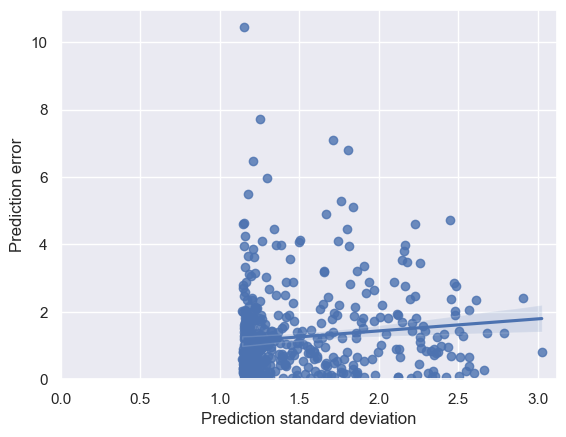

In [ ]:
resid = np.abs(b_y - mean)
sns.regplot(x = std, y = resid)
plt.xlabel("Prediction standard deviation")
plt.ylim(0)
plt.xlim(0)

plt.ylabel("Prediction error")

In [ ]:
np.corrcoef(std, resid)

array([[1.        , 0.11583518],
       [0.11583518, 1.        ]])

In [ ]:
mda(b_y, mean)

0.47046843177189407

In [ ]:
tdt(Wefkj)

NameError: name 'tdt' is not defined

Asymmetric loss function? Discussion around loss function.

## Adding Aleatoric uncertainty

In [ ]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [ ]:
def build_bnn2():
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(input_width, 1))) #(timesteps, features)
    model.add(LSTM(96, return_sequences=True)) #96 #192 #160
    #model.add(LSTM(256, return_sequences=True)) # #256 #(192)
    model.add(LSTM(64)) #64 
    model.add(Dropout(0.2)) #0.2 #0.1 #0.2
    model.add(tfp.layers.DenseVariational(tfp.layers.IndependentNormal.params_size(1), posterior_mean_field, prior_trainable, kl_weight=1/n_samples))
    model.add(tfp.layers.IndependentNormal(1))
    #model.add(Dense(1, activation="relu"))
    
    learning_rate = 0.001 #0.001 #0.0001 #0.001
    metrics = ["mse", "mae", "mape", tf.keras.metrics.RootMeanSquaredError(), qlike]
    model.compile(loss=negloglik, optimizer=Adam(learning_rate=learning_rate), metrics = metrics)
    return model

In [ ]:
bnn2 = build_bnn2()

In [ ]:
MAX_EPOCHS = 0
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=500)

In [ ]:
history = bnn2.fit(w.train, epochs=MAX_EPOCHS,
                      validation_data=w.val,
                      callbacks=[early_stopping])

Epoch 1/10


2023-05-10 14:58:46.802193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-10 14:58:47.266302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-10 14:58:47.390811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-10 14:58:47.528354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-10 14:58:47.875924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-10 14:58:48.064405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/114 [..............................] - ETA: 6:30 - loss: -0.4303 - mse: 0.0586 - mae: 0.2005 - mape: 68.5420 - root_mean_squared_error: 0.2420 - qlike: -0.0136

2023-05-10 14:58:48.251853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


114/114 [==============================] - ETA: 0s - loss: 5.8720 - mse: 1.8686 - mae: 1.0452 - mape: 249815.6406 - root_mean_squared_error: 1.3670 - qlike: nan

2023-05-10 14:58:54.692074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-10 14:58:54.878093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-10 14:58:54.993707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-10 14:58:55.100205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


114/114 [==============================] - 12s 73ms/step - loss: 5.8720 - mse: 1.8686 - mae: 1.0452 - mape: 249815.6406 - root_mean_squared_error: 1.3670 - qlike: nan - val_loss: 4.0774 - val_mse: 1.6700 - val_mae: 0.9922 - val_mape: 5588948.5000 - val_root_mean_squared_error: 1.2923 - val_qlike: nan
Epoch 2/10
114/114 [==============================] - 6s 49ms/step - loss: 2.3162 - mse: 1.7563 - mae: 0.9947 - mape: 7427.9717 - root_mean_squared_error: 1.3252 - qlike: nan - val_loss: 2.9397 - val_mse: 1.9996 - val_mae: 1.1246 - val_mape: 4831117.0000 - val_root_mean_squared_error: 1.4141 - val_qlike: nan
Epoch 3/10
112/114 [============================>.] - ETA: 0s - loss: 2.2384 - mse: 1.9526 - mae: 1.0624 - mape: 964726.3750 - root_mean_squared_error: 1.3974 - qlike: nan

KeyboardInterrupt: 

In [ ]:
predictions = bnn2(b_x)

In [ ]:
b_x = np.concatenate([x for x, y in w.test], axis = 0)
b_y = np.concatenate([y for x, y in w.test], axis = 0)

predictions = bnn2(b_x)

mean = scale.inverse_transform(predictions.mean())

std = scale.inverse_transform(predictions.stddev())

b_y = scale.inverse_transform(b_y.reshape((len(mean), -1)))

In [ ]:
mse = mean_squared_error(b_y, mean)
mae = mean_absolute_error(b_y, mean)
dir = mda(b_y, mean)

print("MSE: ", mse)
print("MAE: ", mae)
print('MDA: ', dir)

MSE:  648.1371243847558
MAE:  24.80316933066319
MDA:  0.0


In [ ]:
mean.shape

(492, 1)

In [ ]:
std.shape

(492, 1)

In [ ]:
a = mean - std

a.shape

(492, 1)

ValueError: operands could not be broadcast together with shapes (49200,) (492,) 

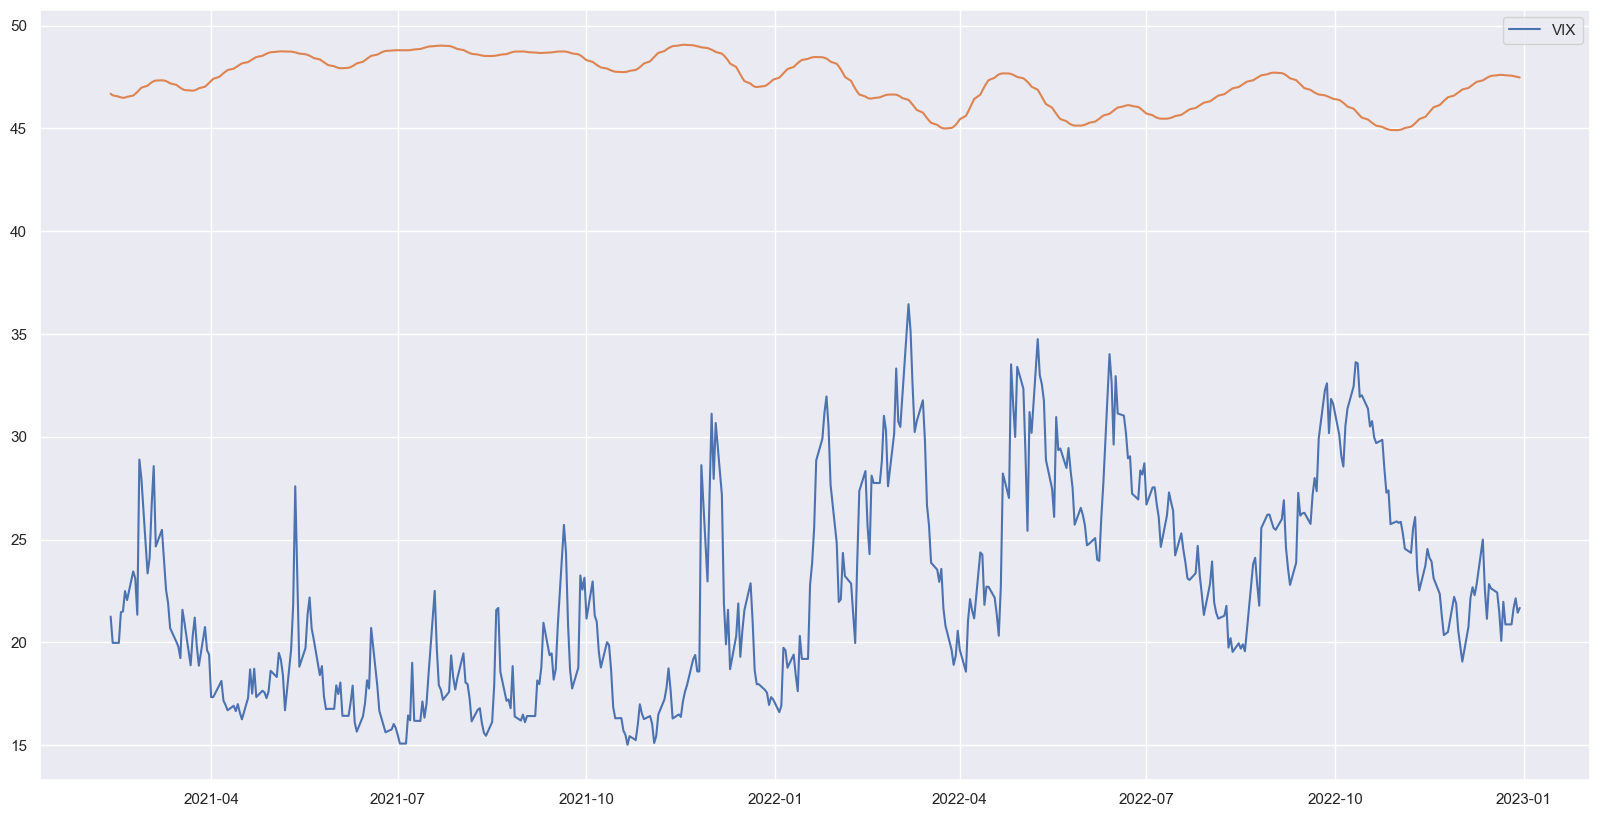

In [ ]:
sns.set()
fig, axs = plt.subplots(figsize=(20, 10))
sns.lineplot(ax = axs, data = test_df.tail(n))
sns.lineplot(ax = axs, data = test_df.tail(n), x = test_df.index[30:], y = mean.flatten())
fill_pred = plt.fill_between(
    preds_interval.Date, 
    (mean - std).reshape((-1, )), (mean + std).reshape((-1, )), 
    color='r', alpha=0.2
)
plt.title("One day ahead predictions Bayesian neural networks")
plt.legend()
plt.show()